## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [19]:
plt.style.use(['dark_background'])

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08009.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08107.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_08190.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07987_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07999_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_08155_P.png')]

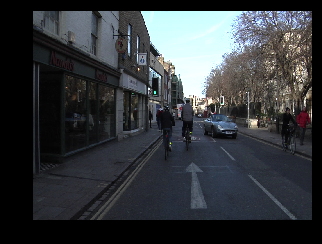

In [20]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

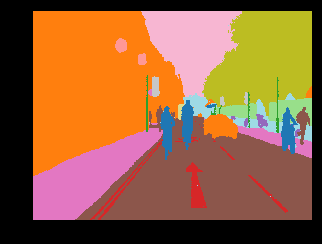

In [21]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [22]:
mask.shape,mask.data

(torch.Size([1, 720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [12]:
size=640
bs=4

In [13]:
data = (ImageFileList.from_folder(path_img)
        .label_from_func(get_y_fn)
        .split_by_fname_file('../valid.txt')
        .datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

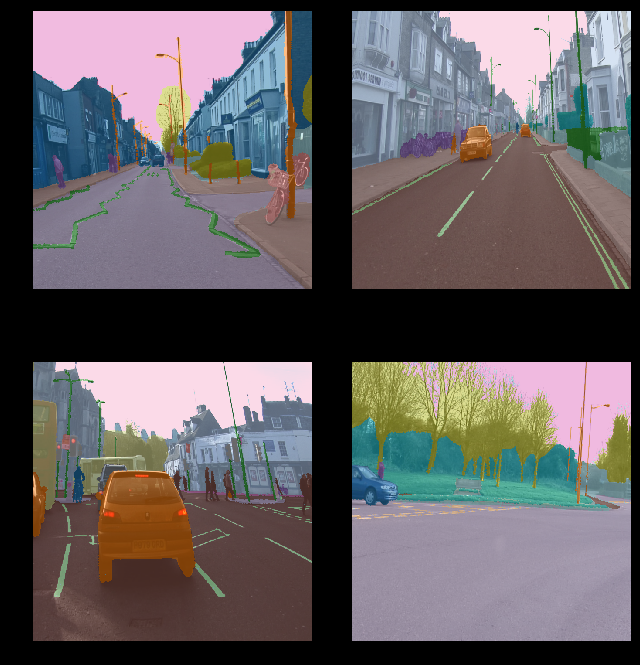

In [23]:
data.show_batch(2)

## Model

In [16]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze()
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [17]:
metrics=acc_camvid
# metrics=accuracy

In [18]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


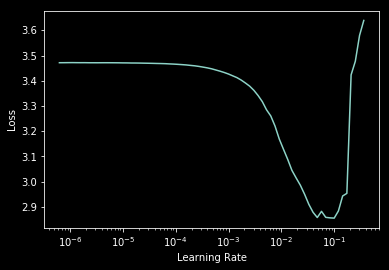

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr = 1e-2

In [26]:
learn.fit_one_cycle(5, slice(lr))

Total time: 02:37
epoch  train_loss  valid_loss  acc_camvid
1      1.036237    1.473241    0.572210    (00:33)
2      0.827691    0.650466    0.835009    (00:30)
3      0.669954    0.606029    0.847092    (00:30)
4      0.592109    0.499325    0.857152    (00:30)
5      0.529673    0.500416    0.853346    (00:30)



In [27]:
learn.fit_one_cycle(5, slice(lr))

Total time: 02:32
epoch  train_loss  valid_loss  acc_camvid
1      0.572699    0.642623    0.816477    (00:30)
2      0.621325    0.545153    0.859826    (00:30)
3      0.566823    0.531785    0.847910    (00:30)
4      0.497544    0.456712    0.866006    (00:30)
5      0.464253    0.422344    0.873443    (00:30)



In [28]:
learn.save('stage-1')

In [29]:
learn.load('stage-1')

In [30]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


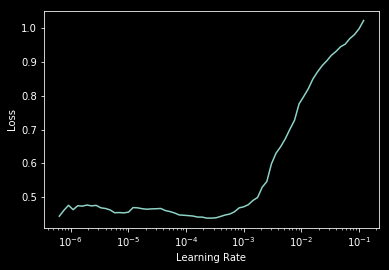

In [31]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, slice(1e-5,lr/5))

Total time: 06:39
epoch  train_loss  valid_loss  acc_camvid
1      0.476839    0.452640    0.872494    (00:33)
2      0.476087    0.433352    0.875471    (00:33)
3      0.467058    0.437772    0.869612    (00:33)
4      0.475351    0.468794    0.868904    (00:33)
5      0.461685    0.443922    0.869515    (00:33)
6      0.434607    0.433422    0.866817    (00:33)
7      0.426970    0.401881    0.881677    (00:33)
8      0.400956    0.379572    0.884080    (00:32)
9      0.375717    0.388340    0.879745    (00:33)
10     0.369958    0.387626    0.876695    (00:33)
11     0.363495    0.374728    0.882055    (00:33)
12     0.349536    0.382812    0.880067    (00:33)



In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2')

In [ ]:
learn.fit_one_cycle(12, slice(1e-5,lr/5))

Total time: 06:40
epoch  train_loss  valid_loss  acc_camvid
1      0.363479    0.372779    0.885822    (00:33)
2      0.372744    0.370301    0.889697    (00:33)
3      0.377817    0.398087    0.887722    (00:33)
4      0.377816    0.400822    0.877530    (00:33)
5      0.379588    0.381926    0.881407    (00:33)
6      0.370663    0.354900    0.898501    (00:33)
7      0.331817    0.341902    0.894362    (00:33)
8      0.329269    0.327356    0.901787    (00:33)
9      0.315665    0.332719    0.899110    (00:33)
10     0.297474    0.337342    0.899688    (00:33)
11     0.299392    0.329972    0.898885    (00:33)
12     0.298601    0.329742    0.900147    (00:33)



In [ ]:
learn.save('stage-3')